# Import and organize the data

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import george
from george import kernels
from george.modeling import Model
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import theano.tensor as tt
from pymc3.gp.util import plot_gp_dist
import seaborn as sns

sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Dark2")

SN = pd.read_csv('LSQ12gdj_photometry.csv')
SN

,event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
0,LSQ12gdj,56237.50000,18.300,NaN,F,NaN,NaN,NaN,"2012ATel.4566....1C,Latest Supernovae"
1,LSQ12gdj,56242.05339,17.487,0.012,F,i,QUEST,ESO Schmidt,2015ApJS..219...13W
2,LSQ12gdj,56242.05846,17.184,0.008,F,r,QUEST,ESO Schmidt,2015ApJS..219...13W
3,LSQ12gdj,56242.06586,17.037,0.008,F,V,QUEST,ESO Schmidt,2015ApJS..219...13W
4,LSQ12gdj,56242.07164,17.006,0.009,F,B,QUEST,ESO Schmidt,2015ApJS..219...13W
...,...,...,...,...,...,...,...,...,...
599,LSQ12gdj,56679.76200,19.351,NaN,T,U,UVOT,Swift,2014Ap&SS.354...89B
600,LSQ12gdj,56679.76270,19.717,NaN,T,B,UVOT,Swift,2014Ap&SS.354...89B
601,LSQ12gdj,56679.76460,20.389,NaN,T,UVW2,UVOT,Swift,2014Ap&SS.354...89B
602,LSQ12gdj,56679.76620,18.782,NaN,T,V,UVOT,Swift,2014Ap&SS.354...89B


In [2]:
time = SN['time']
mag = SN['magnitude']
error = SN['e_magnitude']

UVW2band = np.where(SN['band'] == 'UVW2')[0]
UVM2band = np.where(SN['band'] == 'UVM2')[0]
UVW1band = np.where(SN['band'] == 'UVW1')[0]
Uband = np.where(SN['band'] == 'U')[0]
Bband = np.where(SN['band'] == 'B')[0]
Vband = np.where(SN['band'] == 'V')[0]
Gband = np.where(SN['band'] == 'G')[0]
Rband = np.where(SN['band'] == 'R')[0]
rband = np.where(SN['band'] == 'r')[0]
Iband = np.where(SN['band'] == 'I')[0]
iband = np.where(SN['band'] == 'i')[0]
Zband = np.where(SN['band'] == 'Z')[0]

# get rid of the last weird point really far out in time
UVW2band = UVW2band[:-1]
UVM2band = UVM2band[:-1]
UVW1band = UVW1band[:-1]
Uband = Uband[:-1]
Bband = Bband[:-1]
Vband = Vband[:-1]
Gband = Gband[:-1]
Rband = Rband[:-1]
rband = rband[:-1]
Iband = Iband[:-1]
iband = iband[:-1]
Zband = Zband[:-1]

band_idxs = [UVW2band, UVM2band, UVW1band, Uband, Bband, Vband, Gband, Rband, rband, Iband, iband, Zband]
labels = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V', 'G', 'R', 'r', 'I', 'i', 'Z']

print('Number of points: ', len(SN['band']))
print('Sum of points in bands excluding 1 NaN: ', len(iband)+len(rband)+len(Vband)+len(Bband)+
      len(Uband)+len(Zband)+len(Gband)+len(Iband)+len(UVW1band)+len(UVW2band)+len(UVM2band)+len(Rband))

time = time - 56257.1 # peak of R band

Number of points:  604
Sum of points in bands excluding 1 NaN:  591


### Some variables I might want to change

In [3]:
smooth_len = 10.0
noise = 0.1
sig_fac = 10.0
num_pts = 50

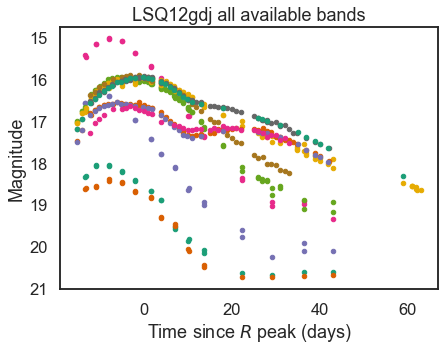

In [4]:
fig = plt.figure(figsize=(7, 5))
for idx, val in enumerate(band_idxs):    
    plt.plot(time[val], mag[val], '.', label=labels[idx])
    #plt.errorbar(time[val], mag[val], error[val], '.', label=labels[idx])
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('LSQ12gdj all available bands')
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
#plt.legend()
plt.savefig('mel_raw_data.png')
plt.show()

# Get initial parameters using np.polyfit

In [5]:
use_band, band_str = Rband, 'R'
time_band = np.asarray(time[use_band])
mag_band = np.asarray(mag[use_band])
error_band = np.asarray(error[use_band])

peak = np.argmin(mag_band)
time_peak = time_band[peak]
print('this should be 0: ', time_peak)

days_after_peak = 15
peakbright_idx = np.argmin(mag_band)
turn = peakbright_idx + days_after_peak
rise_mag = np.asarray(mag_band)[:turn]
decline_mag = np.asarray(mag_band)[turn:]
rise_time = np.asarray(time_band)[:turn]
decline_time = np.asarray(time_band)[turn:]

rise_coeff = np.polyfit(rise_time, rise_mag, 2)
decline_coeff = np.polyfit(decline_time, decline_mag, 2)

p0 = [*rise_coeff, *decline_coeff, time_band[turn]]
print('Initial parameters: ', p0)

print(time_band[turn])

this should be 0:  0.0
Initial parameters:  [0.005176689081918957, 0.0057293237532697865, 15.928226432805014, 0.000641302375314208, 0.002269310817025422, 16.42338688495254, 11.0]
11.0


# Make the mean model and show example of using it

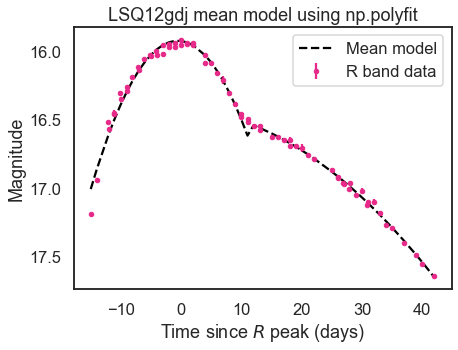

In [6]:
rise_time = time_band[time_band <= 11]
decline_time = time_band[time_band > 11]
rise_mag = p0[0]*rise_time**2 + p0[1]*rise_time + p0[2]
decline_mag = p0[3]*decline_time**2 + p0[4]*decline_time + p0[5]
mag_fit = np.concatenate([rise_mag, decline_mag])

fig = plt.figure(figsize=(7,5))
plt.errorbar(x=time_band, y=mag_band, yerr=error_band, fmt='.', color='C3', label='{} band data'.format(band_str))
plt.plot(time_band, mag_fit, 'k--', label='Mean model')
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('LSQ12gdj mean model using np.polyfit')
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.legend()
plt.savefig('mel_mean_model.png')
plt.show()

# Test single band GP using george

In [7]:
k = kernels.ExpSquaredKernel(metric=50.0)

In [8]:
class GeorgeMeanModel(Model):
    parameter_names = ('r0', 'r1', 'r2', 'd0', 'd1', 'd2', 'turn') # peak, rise1, decline1, turnover time
    def set_vector(self, p):
        self.r0, self.r1, self.r2, self.d0, self.d1, self.d2, self.turn = p
    def get_value(self, t):
        # want out a magnitude, given a time
        # before the time where knee mag is reached
        # follow a one quadratic curve
        # after turnover is reached (in time)
        # follow a different quadratic curve
        
        mag_arr = np.array([])
        for i in t:
            if i < self.turn: # before turnover time
                mag = self.r0*i**2 + self.r1*i + self.r2
            else: # after turnover time
                mag = self.d0*i**2 + self.d1*i + self.d2
            mag_arr = np.append(mag_arr, mag)
        return mag_arr
            
r0_init, r1_init, r2_init = rise_coeff
d0_init, d1_init, d2_init = decline_coeff
turn_init = rise_time[-1]

gp = george.GP(mean=GeorgeMeanModel(r0=r0_init, r1=r1_init, r2=r2_init,
                              d0=d0_init, d1=d1_init, d2=d2_init, turn=turn_init), kernel=k)

In [9]:
gp.get_parameter_dict()

OrderedDict([('mean:r0', 0.005176689081918957),
             ('mean:r1', 0.0057293237532697865),
             ('mean:r2', 15.928226432805014),
             ('mean:d0', 0.000641302375314208),
             ('mean:d1', 0.002269310817025422),
             ('mean:d2', 16.42338688495254),
             ('mean:turn', 11.0),
             ('kernel:metric:log_M_0_0', 3.912023005428146)])

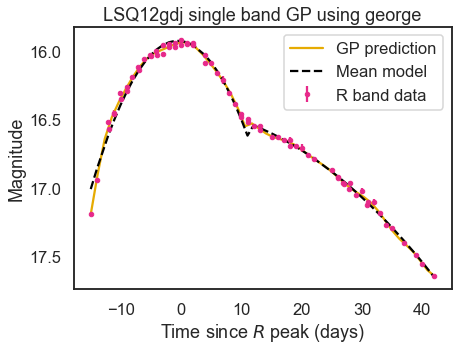

In [10]:
gp.compute(time_band) # error[use_band]

time_pred = np.linspace(min(time_band), max(time_band), num_pts)
mag_pred, pred_var = gp.predict(mag_band, time_pred, return_var=True)

fig = plt.figure(figsize=(7,5))
plt.plot(time_pred, mag_pred, '-', color='C5', label='GP prediction')
plt.plot(time_band, mag_fit, 'k--', label='Mean model')
plt.errorbar(x=time_band, y=mag_band, yerr=error_band, fmt='.', color='C3', label='{} band data'.format(band_str))
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('LSQ12gdj single band GP using george')
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.legend()
plt.savefig('mel_george_GP1.png')
plt.show()

In [11]:
x = time_band
y = mag_band

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
#print(result)

gp.set_parameter_vector(result.x)
#print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

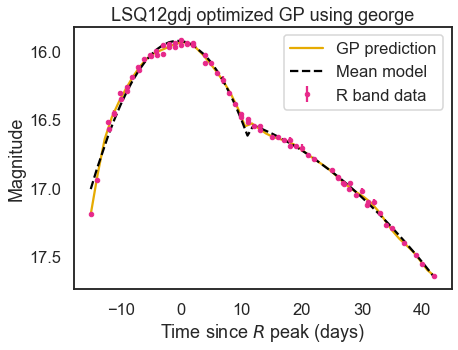

In [12]:
mag_pred, pred_var = gp.predict(mag_band, time_pred, return_var=True)

fig = plt.figure(figsize=(7,5))
plt.plot(time_pred, mag_pred, '-', color='C5', label='GP prediction')
plt.plot(time_band, mag_fit, 'k--', label='Mean model')
plt.errorbar(x=time_band, y=mag_band, yerr=error_band, fmt='.', color='C3', label='{} band data'.format(band_str))
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('LSQ12gdj optimized GP using george')
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.legend()
plt.savefig('mel_george_GP2.png')
plt.show()

# Initialize pymc3 GP for single band

In [13]:
class MagModel(pm.gp.mean.Mean):
    def __init__(self, r0, r1, r2, d0, d1, d2):
        self.r0 = r0
        self.r1 = r1
        self.r2 = r2
        self.d0 = d0
        self.d1 = d1
        self.d2 = d2
    def __call__(self, t):
        rise_time = t[t <= 11]
        decline_time = t[t > 11]
        rise_mag = self.r0*rise_time**2 + self.r1*rise_time + self.r2
        decline_mag = self.d0*decline_time**2 + self.d1*decline_time + self.d2
        mag_arr = tt.concatenate([rise_mag, decline_mag])
        return mag_arr

In [14]:
with pm.Model() as marginal_gp_model:
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=smooth_len)
    
    r0 = pm.Normal('r0', p0[0], sigma=p0[0]*sig_fac, shape=1)
    r1 = pm.Normal('r1', p0[1], sigma=p0[1]*sig_fac, shape=1)
    r2 = pm.Normal('r2', p0[2], sigma=p0[2]*sig_fac, shape=1)
    d0 = pm.Normal('d0', p0[3], sigma=p0[3]*sig_fac, shape=1)
    d1 = pm.Normal('d1', p0[4], sigma=p0[4]*sig_fac, shape=1)
    d2 = pm.Normal('d2', p0[5], sigma=p0[5]*sig_fac, shape=1)

    mean_func = MagModel(r0=r0, r1=r1, r2=r2, d0=d0, d1=d1, d2=d2)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    y_ = gp.marginal_likelihood("mag", X=time_band[:, None], y=mag_band, noise=noise)
    mp = pm.find_MAP()

/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

In [15]:
# new values from x=0 to x=100
X_new = np.linspace(min(time_band)-10, max(time_band)+10, num_pts)[:, None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=50)

/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/50 [00:00<?, ?it/s]/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inste

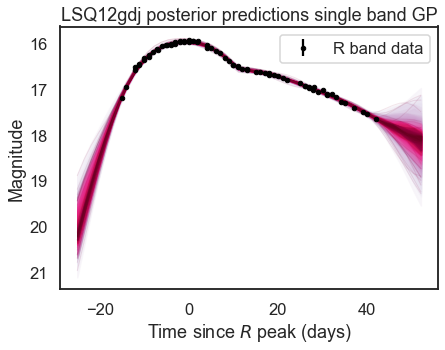

In [16]:
fig = plt.figure(figsize=(7,5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new, palette='PuRd')
plt.errorbar(x=time_band, y=mag_band, yerr=error_band, fmt='.', color='k', label='{} band data'.format(band_str))
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('LSQ12gdj posterior predictions single band GP')
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.legend()
plt.savefig('mel_single_posterior.png')
plt.show()

# Hierarchical model using pymc3

In [ ]:
time_cut = np.asarray(time[:-6])
mag_cut = np.asarray(mag[:-6])
error_cut = np.asarray(error[:-6])
X_new = np.linspace(min(time_cut), max(time_cut), num_pts)[:, None]

with pm.Model() as hierarchical_model: 
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=50.0)
    
    r0 = pm.Normal('r0', p0[0], sigma=p0[0]*sig_fac, shape=len(band_idxs))
    r1 = pm.Normal('r1', p0[1], sigma=p0[1]*sig_fac, shape=len(band_idxs))
    r2 = pm.Normal('r2', p0[2], sigma=p0[2]*sig_fac, shape=len(band_idxs))
    d0 = pm.Normal('d0', p0[3], sigma=p0[3]*sig_fac, shape=len(band_idxs))
    d1 = pm.Normal('d1', p0[4], sigma=p0[4]*sig_fac, shape=len(band_idxs))
    d2 = pm.Normal('d2', p0[5], sigma=p0[5]*sig_fac, shape=len(band_idxs))
    
    mean_func0 = MagModel(r0=r0[0], r1=r1[0], r2=r2[0], d0=d0[0], d1=d1[0], d2=d2[0])
    gp0 = pm.gp.Marginal(mean_func=mean_func0, cov_func=cov_func)
    y0_ = gp0.marginal_likelihood('mag0', X=time_cut[UVW2band][:, None], y=mag_cut[UVW2band], noise=noise)
    mp0 = pm.find_MAP()
    
    mean_func1 = MagModel(r0=r0[1], r1=r1[1], r2=r2[1], d0=d0[1], d1=d1[1], d2=d2[1])
    gp1 = pm.gp.Marginal(mean_func=mean_func1, cov_func=cov_func)
    y1_ = gp1.marginal_likelihood('mag1', X=time_cut[UVM2band][:, None], y=mag_cut[UVM2band], noise=noise)
    mp1 = pm.find_MAP()
    
    mean_func2 = MagModel(r0=r0[2], r1=r1[2], r2=r2[2], d0=d0[2], d1=d1[2], d2=d2[2])
    gp2 = pm.gp.Marginal(mean_func=mean_func2, cov_func=cov_func)
    y2_ = gp2.marginal_likelihood('mag2', X=time_cut[UVW1band][:, None], y=mag_cut[UVW1band], noise=noise)
    mp2 = pm.find_MAP()
    
    mean_func3 = MagModel(r0=r0[3], r1=r1[3], r2=r2[3], d0=d0[3], d1=d1[3], d2=d2[3])
    gp3 = pm.gp.Marginal(mean_func=mean_func3, cov_func=cov_func)
    y3_ = gp3.marginal_likelihood('mag3', X=time_cut[Uband][:, None], y=mag_cut[Uband], noise=noise)
    mp3 = pm.find_MAP()
    
    mean_func4 = MagModel(r0=r0[4], r1=r1[4], r2=r2[4], d0=d0[4], d1=d1[4], d2=d2[4])
    gp4 = pm.gp.Marginal(mean_func=mean_func4, cov_func=cov_func)
    y4_ = gp4.marginal_likelihood('mag4', X=time_cut[Bband][:, None], y=mag_cut[Bband], noise=noise)
    mp4 = pm.find_MAP()
    
    mean_func5 = MagModel(r0=r0[5], r1=r1[5], r2=r2[5], d0=d0[5], d1=d1[5], d2=d2[5])
    gp5 = pm.gp.Marginal(mean_func=mean_func5, cov_func=cov_func)
    y5_ = gp5.marginal_likelihood('mag5', X=time_cut[Vband][:, None], y=mag_cut[Vband], noise=noise)
    mp5 = pm.find_MAP()
        
    mean_func6 = MagModel(r0=r0[6], r1=r1[6], r2=r2[6], d0=d0[6], d1=d1[6], d2=d2[6])
    gp6 = pm.gp.Marginal(mean_func=mean_func6, cov_func=cov_func)
    y6_ = gp6.marginal_likelihood('mag6', X=time_cut[Gband][:, None], y=mag_cut[Gband], noise=noise)
    mp6 = pm.find_MAP()
    
    mean_func7 = MagModel(r0=r0[7], r1=r1[7], r2=r2[7], d0=d0[7], d1=d1[7], d2=d2[7])
    gp7 = pm.gp.Marginal(mean_func=mean_func7, cov_func=cov_func)
    y7_ = gp7.marginal_likelihood('mag7', X=time_cut[Rband][:, None], y=mag_cut[Rband], noise=noise)
    mp7 = pm.find_MAP()
    
    mean_func8 = MagModel(r0=r0[8], r1=r1[8], r2=r2[8], d0=d0[8], d1=d1[8], d2=d2[8])
    gp8 = pm.gp.Marginal(mean_func=mean_func8, cov_func=cov_func)
    y8_ = gp8.marginal_likelihood('mag8', X=time_cut[rband][:, None], y=mag_cut[rband], noise=noise)
    mp8 = pm.find_MAP()
    
    mean_func9 = MagModel(r0=r0[9], r1=r1[9], r2=r2[9], d0=d0[9], d1=d1[9], d2=d2[9])
    gp9 = pm.gp.Marginal(mean_func=mean_func9, cov_func=cov_func)
    y9_ = gp9.marginal_likelihood('mag9', X=time_cut[Iband][:, None], y=mag_cut[Iband], noise=noise)
    mp9 = pm.find_MAP()
    
    mean_func10 = MagModel(r0=r0[10], r1=r1[10], r2=r2[10], d0=d0[10], d1=d1[10], d2=d2[10])
    gp10 = pm.gp.Marginal(mean_func=mean_func10, cov_func=cov_func)
    y10_ = gp10.marginal_likelihood('mag10', X=time_cut[iband][:, None], y=mag_cut[iband], noise=noise)
    mp10 = pm.find_MAP()
    
    mean_func11 = MagModel(r0=r0[11], r1=r1[11], r2=r2[11], d0=d0[11], d1=d1[11], d2=d2[11])
    gp11 = pm.gp.Marginal(mean_func=mean_func11, cov_func=cov_func)
    y11_ = gp11.marginal_likelihood('mag11', X=time_cut[Zband][:, None], y=mag_cut[Zband], noise=noise)
    mp11 = pm.find_MAP()

/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = 2.4066, ||grad|| = 199.34: 100%|██████████| 76/76 [00:00<00:00, 1203.01it/s]    
/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional i

In [ ]:
# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred0 = gp0.conditional("f_pred0", X_new)
    f_pred1 = gp1.conditional("f_pred1", X_new)
    f_pred2 = gp2.conditional("f_pred2", X_new)
    f_pred3 = gp3.conditional("f_pred3", X_new)
    f_pred4 = gp4.conditional("f_pred4", X_new)
    f_pred5 = gp5.conditional("f_pred5", X_new)
    f_pred6 = gp6.conditional("f_pred6", X_new)
    f_pred7 = gp7.conditional("f_pred7", X_new)
    f_pred8 = gp8.conditional("f_pred8", X_new)
    f_pred9 = gp9.conditional("f_pred9", X_new)
    f_pred10 = gp10.conditional("f_pred10", X_new)
    f_pred11 = gp11.conditional("f_pred11", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with marginal_gp_model:
    pred_samples0 = pm.sample_posterior_predictive([mp0], vars=[f_pred0], samples=20)
    pred_samples1 = pm.sample_posterior_predictive([mp1], vars=[f_pred1], samples=20)
    pred_samples2 = pm.sample_posterior_predictive([mp2], vars=[f_pred2], samples=20)
    pred_samples3 = pm.sample_posterior_predictive([mp3], vars=[f_pred3], samples=20)
    pred_samples4 = pm.sample_posterior_predictive([mp4], vars=[f_pred4], samples=20)
    pred_samples5 = pm.sample_posterior_predictive([mp5], vars=[f_pred5], samples=20)
    pred_samples6 = pm.sample_posterior_predictive([mp6], vars=[f_pred6], samples=20)
    pred_samples7 = pm.sample_posterior_predictive([mp7], vars=[f_pred7], samples=20)
    pred_samples8 = pm.sample_posterior_predictive([mp8], vars=[f_pred8], samples=20)
    pred_samples9 = pm.sample_posterior_predictive([mp9], vars=[f_pred9], samples=20)
    pred_samples10 = pm.sample_posterior_predictive([mp10], vars=[f_pred10], samples=20)
    pred_samples11 = pm.sample_posterior_predictive([mp11], vars=[f_pred11], samples=20)

In [ ]:
# plot the results
band_idxs = [UVW2band, UVM2band, UVW1band, Uband, Bband, Vband, Gband, Rband, rband, Iband, iband, Zband]

fig = plt.figure(figsize=(7,5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples0["f_pred0"], X_new, palette='GnBu')
plt.errorbar(x=time_cut[UVW2band], y=mag_cut[UVW2band], yerr=error_cut[UVW2band], fmt='.', label='UVW2')
plot_gp_dist(ax, pred_samples1["f_pred1"], X_new, palette='Oranges')
plt.errorbar(x=time_cut[UVM2band], y=mag_cut[UVM2band], yerr=error_cut[UVM2band], fmt='.', label='UVM2')
plot_gp_dist(ax, pred_samples2["f_pred2"], X_new, palette='Purples')
plt.errorbar(x=time_cut[UVW1band], y=mag_cut[UVW1band], yerr=error_cut[UVW1band], fmt='.', label='UVW1')
plot_gp_dist(ax, pred_samples3["f_pred3"], X_new, palette='PuRd')
plt.errorbar(x=time_cut[Uband], y=mag_cut[Uband], yerr=error_cut[Uband], fmt='.', label='U')
plot_gp_dist(ax, pred_samples4["f_pred4"], X_new, palette='YlGn')
plt.errorbar(x=time_cut[Bband], y=mag_cut[Bband], yerr=error_cut[Bband], fmt='.', label='B')
plot_gp_dist(ax, pred_samples5["f_pred5"], X_new, palette='OrRd')
plt.errorbar(x=time_cut[Vband], y=mag_cut[Vband], yerr=error_cut[Vband], fmt='.', label='V')
plot_gp_dist(ax, pred_samples6["f_pred6"], X_new, palette='YlOrBr')
plt.errorbar(x=time_cut[Gband], y=mag_cut[Gband], yerr=error_cut[Gband], fmt='.', label='G')
plot_gp_dist(ax, pred_samples7["f_pred7"], X_new, palette='Greys')
plt.errorbar(x=time_cut[Rband], y=mag_cut[Rband], yerr=error_cut[Rband], fmt='.', label='R')
plot_gp_dist(ax, pred_samples8["f_pred8"], X_new, palette='Blues')
plt.errorbar(x=time_cut[rband], y=mag_cut[rband], yerr=error_cut[rband], fmt='.', label='r')
plot_gp_dist(ax, pred_samples9["f_pred9"], X_new, palette='Reds')
plt.errorbar(x=time_cut[Iband], y=mag_cut[Iband], yerr=error_cut[Iband], fmt='.', label='I')
plot_gp_dist(ax, pred_samples10["f_pred10"], X_new, palette='BuPu')
plt.errorbar(x=time_cut[iband], y=mag_cut[iband], yerr=error_cut[iband], fmt='.', label='i')
plot_gp_dist(ax, pred_samples11["f_pred11"], X_new, palette='RdPu')
plt.errorbar(x=time_cut[Zband], y=mag_cut[Zband], yerr=error_cut[Zband], fmt='.', label='Z')
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('LSQ12gdj posterior predictions all bands')
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
#plt.legend()
plt.savefig('mel_all_bands.png')
plt.show()

# Get median posterior predictions

In [ ]:
med0 = np.median(pred_samples0['f_pred0'], axis=0)
med1 = np.median(pred_samples1['f_pred1'], axis=0)
med2 = np.median(pred_samples2['f_pred2'], axis=0)
med3 = np.median(pred_samples3['f_pred3'], axis=0)
med4 = np.median(pred_samples4['f_pred4'], axis=0)
med5 = np.median(pred_samples5['f_pred5'], axis=0)
med6 = np.median(pred_samples6['f_pred6'], axis=0)
med7 = np.median(pred_samples7['f_pred7'], axis=0)
med8 = np.median(pred_samples8['f_pred8'], axis=0)
med9 = np.median(pred_samples9['f_pred9'], axis=0)
med10 = np.median(pred_samples10['f_pred10'], axis=0)
med11 = np.median(pred_samples11['f_pred11'], axis=0)


fig = plt.figure(figsize=(7,5))
plt.plot(X_new, med0, 'C0-')
plt.errorbar(x=time_cut[UVW2band], y=mag_cut[UVW2band], yerr=error_cut[UVW2band], fmt='.', color='C0', label='UVW2')
plt.plot(X_new, med1, 'C1--')
plt.errorbar(x=time_cut[UVM2band], y=mag_cut[UVM2band], yerr=error_cut[UVM2band], fmt='.', color='C1', label='UVM2')
plt.plot(X_new, med2, 'C2-.')
plt.errorbar(x=time_cut[UVW1band], y=mag_cut[UVW1band], yerr=error_cut[UVW1band], fmt='.', color='C2', label='UVW1')
plt.plot(X_new, med3, 'C3:')
plt.errorbar(x=time_cut[Uband], y=mag_cut[Uband], yerr=error_cut[Uband], fmt='.', color='C3', label='U')
plt.plot(X_new, med4, 'C4-')
plt.errorbar(x=time_cut[Bband], y=mag_cut[Bband], yerr=error_cut[Bband], fmt='.', color='C4', label='B')
plt.plot(X_new, med5, 'C5--')
plt.errorbar(x=time_cut[Vband], y=mag_cut[Vband], yerr=error_cut[Vband], fmt='.', color='C5', label='V')
plt.plot(X_new, med6, 'C6-.')
plt.errorbar(x=time_cut[Gband], y=mag_cut[Gband], yerr=error_cut[Gband], fmt='.', color='C6', label='G')
plt.plot(X_new, med7, 'C7:')
plt.errorbar(x=time_cut[Rband], y=mag_cut[Rband], yerr=error_cut[Rband], fmt='.', color='C7', label='R')
plt.plot(X_new, med8, 'C8-')
plt.errorbar(x=time_cut[rband], y=mag_cut[rband], yerr=error_cut[rband], fmt='.', color='C8', label='r')
plt.plot(X_new, med9, 'C9--')
plt.errorbar(x=time_cut[Iband], y=mag_cut[Iband], yerr=error_cut[Iband], fmt='.', color='C9', label='I')
plt.plot(X_new, med10, '-.', color='C10')
plt.errorbar(x=time_cut[iband], y=mag_cut[iband], yerr=error_cut[iband], fmt='.', color='C10', label='i')
plt.plot(X_new, med11, ':', color='C11')
plt.errorbar(x=time_cut[Zband], y=mag_cut[Zband], yerr=error_cut[Zband], fmt='.', color='C11', label='Z')
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('LSQ12gdj median posterior predictions')
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
#plt.legend()
plt.savefig('mel_median.png')
plt.show()

In [ ]:
#standard deviation of our gps to be the error in the mags, added in quadrature over all bands
std0 = np.std(pred_samples0['f_pred0'], axis=0)
std1 = np.std(pred_samples1['f_pred1'], axis=0)
std2 = np.std(pred_samples2['f_pred2'], axis=0)
std3 = np.std(pred_samples3['f_pred3'], axis=0)
std4 = np.std(pred_samples4['f_pred4'], axis=0)
std5 = np.std(pred_samples5['f_pred5'], axis=0)
std6 = np.std(pred_samples6['f_pred6'], axis=0)
std7 = np.std(pred_samples7['f_pred7'], axis=0)
std8 = np.std(pred_samples8['f_pred8'], axis=0)
std9 = np.std(pred_samples9['f_pred9'], axis=0)
std10 = np.std(pred_samples10['f_pred10'], axis=0)
std11 = np.std(pred_samples11['f_pred11'], axis=0)

fig = plt.figure(figsize=(7,5))
plt.errorbar(x=X_new, y=med0, yerr=std0, fmt='.', color='C0', label='UVW2')
plt.errorbar(x=X_new, y=med1, yerr=std1, fmt='.', color='C1', label='UVM2')
plt.errorbar(x=X_new, y=med2, yerr=std2, fmt='.', color='C2', label='UVW1')
plt.errorbar(x=X_new, y=med3, yerr=std3, fmt='.', color='C3', label='U')
plt.errorbar(x=X_new, y=med4, yerr=std4, fmt='.', color='C4', label='B')
plt.errorbar(x=X_new, y=med5, yerr=std5, fmt='.', color='C5', label='V')
plt.errorbar(x=X_new, y=med6, yerr=std6, fmt='.', color='C6', label='G')
plt.errorbar(x=X_new, y=med7, yerr=std7, fmt='.', color='C7', label='R')
plt.errorbar(x=X_new, y=med8, yerr=std8, fmt='.', color='C8', label='r')
plt.errorbar(x=X_new, y=med9, yerr=std9, fmt='.', color='C9', label='I')
plt.errorbar(x=X_new, y=med10, yerr=std10, fmt='.', color='C10', label='i')
plt.errorbar(x=X_new, y=med11, yerr=std11, fmt='.', color='C11', label='Z')
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('LSQ12gdj standard deviations')
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
#plt.legend()
plt.savefig('mel_std.png')
plt.show()

# Calculate flux, luminosity, and temperature

In [ ]:
wave = np.array([2030, 2231, 2634, 3600, 4380, 5450, 6260, 6410, 6730, 7670, 7980, 8890]) # Angstroms, from superbol
flux0 = 1e-11*np.array([536.2, 463.7, 412.3, 417.5, 632.0, 
                        363.1, 278.0, 217.7, 240.0, 185.2, 112.6, 137.8]) # erg/s/cm2/A, from superbol

def calc_bolF(mag, flux0, wave):
    flux = flux0*10**(-mag/2.5)
    return np.trapz(flux, wave)

def calc_bolL(bolF, dSN):
    return bolF*4*np.pi*dSN**2

def calc_T(bolL, RSN):
    T = (bolL/(4*np.pi*5.6704*1e-5*RSN**2))**(0.25) # sb 5.6704*1e-5 erg⋅cm−2⋅s−1⋅K−4
    return T

mag_per_x = (np.stack((med0, med1, med2, med3, med4, med5, med8, med7, med6, med10, med9, med11))).T
error_per_x = (np.stack((std0, std1, std2, std3, std4, std5, std8, std7, std6, std10, std9, std11))).T
error_over_allwave = np.array([])
for i in error_per_x:
    error = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2 + i[3]**2 + i[4]**2 + i[5]**2 + 
             i[6]**2 + i[7]**2 + i[8]**2 + i[9]**2 + i[10]**2 + i[11]**2)
    error_over_allwave = np.append(error_over_allwave, error)
    
bolF = calc_bolF(mag_per_x, flux0, wave)
error_bolF = error_over_allwave*bolF
bolL = calc_bolL(bolF, 4.629e26) # distance in cm
error_bolL = error_over_allwave*bolL
T = calc_T(bolL, 1e15) # radius in cm
error_T = error_over_allwave*T

print(error_over_allwave)

In [ ]:
fig = plt.figure(figsize=(7, 5))
plt.errorbar(x=X_new, y=bolF, yerr=error_bolF, fmt='.', color='C0', label='This work')
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel(r'Flux (erg/s/cm$^2$/$\AA$)')
plt.title('LSQ12gdj bolometric flux')
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
#plt.legend()
plt.savefig('mel_bolF.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(7, 5))
plt.errorbar(x=X_new, y=bolL, yerr=error_bolL, fmt='.', color='C0', label='This work')
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Luminosity (erg/s)')
plt.title('LSQ12gdj bolometric luminosity')
plt.yscale('log')
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
#plt.legend()
plt.savefig('mel_bolL.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(7, 5))
plt.errorbar(x=X_new, y=T, yerr=error_T, fmt='.', color='C0', label='This work')
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Temperature (K)')
plt.title('LSQ12gdj temperature (assuming $R$=1e15 cm)')
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
#plt.legend()
plt.savefig('mel_temp.png')
plt.show()

# Comparing to superbol

In [ ]:
# what superbol does
def bb(lamb, T, R):
#    Calculate the corresponding blackbody radiance for a set
#    of wavelengths given a temperature and radiance.
#    Parameters
#    ---------------
#    lam: Reference wavelengths in Angstroms
#    T:   Temperature in Kelvin
#    R:   Radius in cm
    # Planck Constant in cm^2 * g / s
    h = 6.62607E-27
    # Speed of light in cm/s
    c = 2.99792458E10
    # Convert wavelength to cm
    lam_cm = lam * 1e-8
    # Boltzmann Constant in cm^2 * g / s^2 / K
    k_B = 1.38064852E-16
    # Calculate Radiance B_lam, in units of (erg / s) / cm ^ 2 / cm
    exponential = (h * c) / (lam_cm * k_B * T)
    B_lam = ((2 * np.pi * h * c ** 2) / (lam_cm ** 5)) / (np.exp(exponential) - 1)
    # Multiply by the surface area
    A = 4*np.pi*R**2
    # Output radiance in units of (erg / s) / Angstrom
    Radiance = B_lam * A / 1e8
    return Radiance